# HW 1: SIR and SEIR Model Implementation for Pandemic Spread

In [61]:
import numpy as np
from scipy.integrate import solve_ivp

### A. Model Implementation

In [62]:
def dS_dt(S, I, beta):
    """dS/dt = -beta * S * I"""
    return -beta * S * I

def dI_dt(S, I,beta, gamma):
    """dI/dt = beta * S * I - gamma * I"""
    return beta * S * I - gamma * I

def dR_dt(I, gamma):
    """dR/dt = gamma * I"""
    return gamma * I

def sir_rhs_vector(t, y, beta, gamma):
    """
    Vector form for ODE solver.
    y = [S, I, R]
    """
    S, I, R = y
    return [
        dS_dt(S, I, beta),
        dI_dt(S, I, beta, gamma),
        dR_dt(I, gamma),
    ]

def simulate_sir_rk45(S0, I0, R0, beta, gamma, t_end, dt):
    """
    Adaptive RK45 integrator (solve_ivp) for SIR.
    Returns: t, S, I, R (arrays evaluated on t_eval grid for easy plotting)
    """
    t_eval = np.arange(0.0, t_end + 1e-12, dt)
    sol = solve_ivp(
        fun=lambda t, y: sir_rhs_vector(t, y, beta, gamma),
        t_span=(0.0, t_end),
        y0=[float(S0), float(I0), float(R0)],
        method="RK45",
        t_eval=t_eval,
        max_step=dt,   
        rtol=1e-6,
        atol=1e-9,
    )

    t = sol.t
    S, I, R = sol.y
    S = np.maximum(S, 0.0)
    I = np.maximum(I, 0.0)
    R = np.maximum(R, 0.0)
    return t, S, I, R

### B. SIR Model Simulation

In [63]:
beta = 0.0003    
gamma = 0.1
S0, I0, R0 = 999, 1, 0
t_end, dt = 150.0, 0.1

t, S, I, R = simulate_sir_rk45(S0, I0, R0, beta, gamma, t_end=t_end, dt=dt)

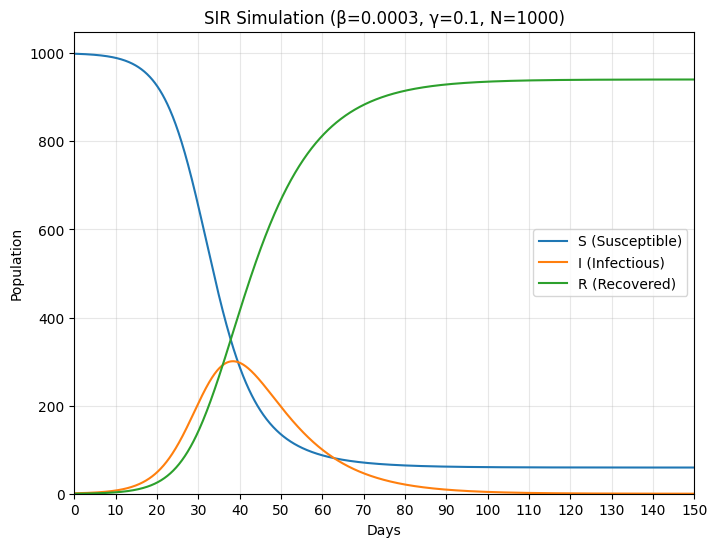

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(t, S, label="S (Susceptible)")
plt.plot(t, I, label="I (Infectious)")
plt.plot(t, R, label="R (Recovered)")

plt.xlabel("Days")
plt.ylabel("Population")
plt.title("SIR Simulation (β=0.0003, γ=0.1, N=1000)")
plt.legend()
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.set_xlim(0, 150)
ax.set_xticks(list(range(0, 151, 10))) 
ax.set_ylim(bottom=0)                   

plt.show()

### C. Analysis and Interpretation
#### i. Infection peak

In [65]:
idx_peak = int(np.argmax(I))
t_peak = float(t[idx_peak])
I_peak = float(I[idx_peak])

print(f"Peak I(t): I_max = {I_peak:.6g} at t = {t_peak:.3f} days")

S_peak_theory = gamma / beta
S_at_peak     = float(S[idx_peak])

print(f"S*(theoretical_peak) = gamma/beta = {S_peak_theory:.6g}")
print(f"S(at_peak_from_simulation) = {S_at_peak:.6g}")

Peak I(t): I_max = 300.793 at t = 38.400 days
S*(theoretical_peak) = gamma/beta = 333.333
S(at_peak_from_simulation) = 331.992


The value of **gamma** and **beta** contribute to the peak.  

Since  

$$
\frac{dI}{dt} = \beta S I - \gamma I,
$$  

when \(I\) reaches its peak it means  

$$
\frac{dI}{dt} = \beta S I - \gamma I = 0,
$$  
$$
\beta S = \gamma \Rightarrow S = \frac{\gamma}{\beta} = \frac{0.1}{0.0003} \approx 333.33.
$$  

As you can see, when \(I\) reaches the peak in the simulation, its \(S\) value is **331.992**,  
which is close to **333.33**, proving this assumption.

#### ii. Basic reproductive number R₀

The basic reproductive number is defined as:

$$
R_0 = \frac{\beta}{\gamma}
$$

Therefore:

$$
R_0 = \frac{0.0003}{0.1} = 0.003
$$

This result means each infected individual would infect ~**0.003** other people, and since it is smaller than the recovery rate $\gamma = 0.1$ (much larger than 0.003), that means when an infected individual infects ~0.003 people (assume), **0.1** infected people will be recovered. That makes the infection not spread widely, and finally all infected individuals will be recovered.

#### iii. Pandemic dynamics

From the plot above, the trend of S, I, R is:
- **S (Susceptible)** keeps going down over time because people keep getting infected. Once they move to I or R, they never go back to S. 

- **I (Infectious)** first goes up and then goes down. It increases when there are still many susceptible people, but once most of them are infected or recovered, it starts to fall. The peak happens when the number of susceptible people drops to around 333 (which matches the theory βS = γ).  

- **R (Recovered)** keeps increasing since more people recover every day and do not get sick again.  

In the SIR model, **the spread and eventual containment** come from how **S**, **I**, and **R** interact. When **S** is large and there is some **I**, the number of infected people increases — that’s **the spread**. At the same time, recoveries happen by **γ·I**, moving people from **I → R**. Each new infection removes one person from **S**, so **S** keeps getting smaller. When **S** decreases to around **γ/β** (so **β·S = γ**), the balance flips — recoveries **γ·I** become stronger than new infections **β·S·I**. As a result, **I(t)** starts to fall, **R** keeps going up, and the system naturally moves into **eventual containment**, where most of the population ends up in **R**.

### D. SEIR Model with Births and Deaths
#### i. Implement the susceptible-exposed-infectious-recovered (SEIR) model

In [66]:
def dS_dt_seir(S, E, I, R, beta, mu):
    """dS/dt = μ*(S+E+I+R) - beta*S*I - μ*S"""
    N = S + E + I + R
    return mu * N - beta * S * I - mu * S

def dE_dt_seir(S, E, I, beta, sigma, mu):
    """dE/dt = beta*S*I - (sigma + μ)*E"""
    return beta * S * I - (sigma + mu) * E

def dI_dt_seir(E, I, gamma, sigma, mu):
    """dI/dt = sigma*E - (gamma + μ)*I"""
    return sigma * E - (gamma + mu) * I

def dR_dt_seir(I, R, gamma, mu):
    """dR/dt = gamma*I - μ*R"""
    return gamma * I - mu * R

def seir_rhs_vector(t, y, beta, gamma, sigma, mu):
    """
    Vector form for ODE solver.
    y = [S, E, I, R]
    """
    S, E, I, R = y
    return [
        dS_dt_seir(S, E, I, R, beta, mu),
        dE_dt_seir(S, E, I, beta, sigma, mu),
        dI_dt_seir(E, I, gamma, sigma, mu),
        dR_dt_seir(I, R, gamma, mu),
    ]

def simulate_seir_rk45(S0, E0, I0, R0, beta, gamma, sigma, mu, t_end, dt):
    """
    Adaptive RK45 integrator (solve_ivp) for SEIR with births/deaths.
    Returns: t, S, E, I, R (arrays evaluated on t_eval grid)
    """
    t_eval = np.arange(0.0, t_end + 1e-12, dt)
    sol = solve_ivp(
        fun=lambda t, y: seir_rhs_vector(t, y, beta, gamma, sigma, mu),
        t_span=(0.0, t_end),
        y0=[float(S0), float(E0), float(I0), float(R0)],
        method="RK45",
        t_eval=t_eval,
        max_step=dt,
        rtol=1e-6,
        atol=1e-9,
    )

    t = sol.t
    S, E, I, R = sol.y

    S = np.maximum(S, 0.0)
    E = np.maximum(E, 0.0)
    I = np.maximum(I, 0.0)
    R = np.maximum(R, 0.0)
    return t, S, E, I, R

#### ii. Simulate for both 365 and 1200 days with S(0) = 990, E(0) = 9, I(0) = 1, R(0) = 0, and parameters β = 0.3 × 10−3, γ = 0.1, σ= 0.2, and µ= 0.01. Plot the compartment populations over time.

In [67]:
beta = 0.0003    
gamma = 0.1
sigma = 0.2
mu = 0.01
S0, E0, I0, R0 = 990, 9, 1, 0

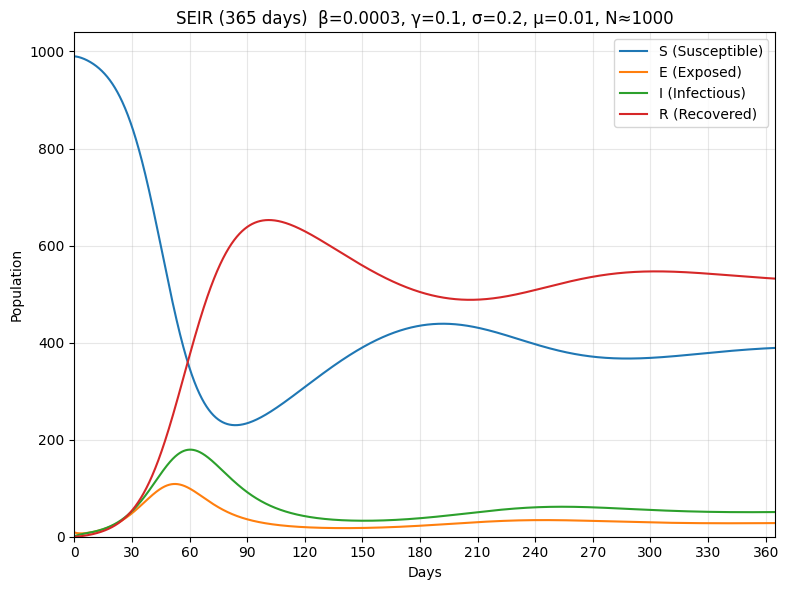

In [68]:
# 365-day simulation 
t_end_365, dt = 365.0, 0.1
t365, S365, E365, I365, R365 = simulate_seir_rk45(S0, E0, I0, R0, beta, gamma, sigma, mu, t_end_365, dt)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(t365, S365, label="S (Susceptible)")
plt.plot(t365, E365, label="E (Exposed)")
plt.plot(t365, I365, label="I (Infectious)")
plt.plot(t365, R365, label="R (Recovered)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("SEIR (365 days)  β=0.0003, γ=0.1, σ=0.2, μ=0.01, N≈1000")
plt.legend()
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.set_xlim(0, 365)
ax.set_xticks(list(range(0, 366, 30)))  # ticks every 30 days
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

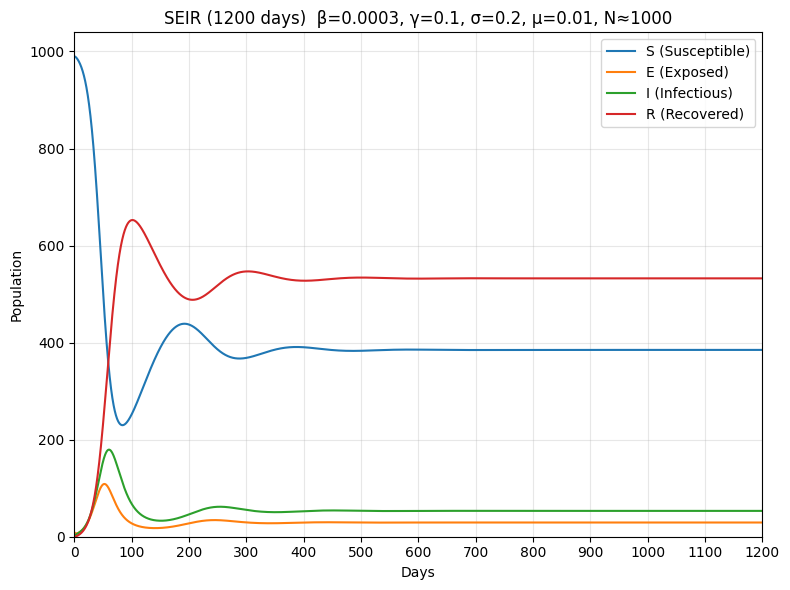

In [69]:
# 1200-day simulation
t_end_1200 = 1200.0
t1200, S1200, E1200, I1200, R1200 = simulate_seir_rk45(S0, E0, I0, R0, beta, gamma, sigma, mu, t_end_1200, dt)

plt.figure(figsize=(8, 6))
plt.plot(t1200, S1200, label="S (Susceptible)")
plt.plot(t1200, E1200, label="E (Exposed)")
plt.plot(t1200, I1200, label="I (Infectious)")
plt.plot(t1200, R1200, label="R (Recovered)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.title("SEIR (1200 days)  β=0.0003, γ=0.1, σ=0.2, μ=0.01, N≈1000")
plt.legend()
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.set_xlim(0, 1200)
ax.set_xticks(list(range(0, 1201, 100)))  # ticks every 100 days
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

#### iii. Discuss the pattern observed in the number of infections in terms of waves of the pandemic.

In the 365-day SEIR run, I(t) shows a large initial peak followed by a smaller second bump.  

In the 1200-day run, I(t) exhibits damped oscillations—each peak becomes smaller and gradually settles toward a low, steady level. 
 
The mechanism is: the infection term **β·S·I** increases infections when **S** is still large, creating the first wave. The **E→I** delay (**σ**) introduces a time lag, which makes the system overshoot and produces the second smaller wave. When **μ > 0**, births continuously add new susceptibles (**S**) back into the population, allowing additional rises, but each cycle is weaker as the system moves toward equilibrium. Overall, multiple early waves appear and then gradually damp into a small endemic level.

#### iv. Discuss the effect of the exposed compartment and birth/death rates on the pandemic dynamics.

The **exposed compartment (E)** adds a delay between infection and becoming infectious. This delay smooths the infection curve and shifts the peak later because individuals spend time in **E** before moving to **I**. It also creates a lag that can cause small overshoots or extra waves, as seen in the plots.  

The **birth and death rate (μ)** affects the long-term behavior by continuously adding new susceptibles (**S**) through births and removing individuals from all compartments through deaths. As a result, **S** is slowly replenished, allowing new infection waves to appear after the first one.  

Over time, the combined effects of the incubation delay (**σ**) and demographic turnover (**μ**) lead the system toward a stable equilibrium where the infection persists at a low, steady level instead of disappearing completely.

### E. Sensitivity Analysis
#### i. Conduct a sensitivity analysis on the SEIR model from the previous part by varying β (0.1 × 10−3 to 0.5 × 10−3) and γ (0.05 to 0.2).

In [70]:
sigma = 0.2
mu = 0.01
S0, E0, I0, R0 = 990, 9, 1, 0
t_end, dt = 365, 0.1

beta_grid  = [0.0001,0.0002, 0.0003, 0.0004, 0.0005]
gamma_grid = [0.05, 0.10, 0.15, 0.20] 

beta_baseline = 0.0003
gamma_baseline = 0.10

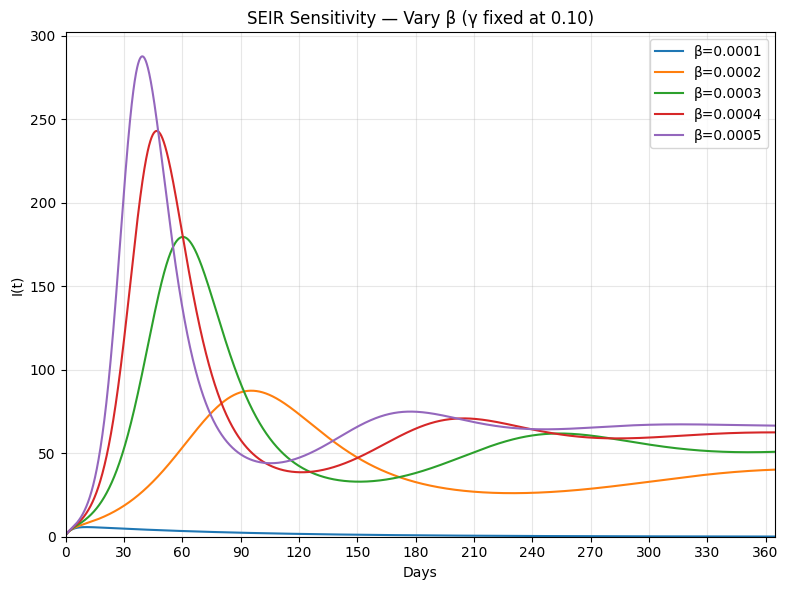

In [71]:
# effect of β (hold γ fixed) 
peak_reports_beta = []
plt.figure(figsize=(8, 6))
for beta in beta_grid:
    t, S, E, I, R = simulate_seir_rk45(S0, E0, I0, R0, beta, gamma_baseline, sigma, mu, t_end, dt)
    plt.plot(t, I, label=f"β={beta}")
    idx_peak = int(np.argmax(I))
    peak_reports_beta.append((beta, float(I[idx_peak]), float(t[idx_peak])))

plt.xlabel("Days")
plt.ylabel("I(t)")
plt.title("SEIR Sensitivity — Vary β (γ fixed at 0.10)")
plt.legend()
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.set_xlim(0, t_end)
ax.set_xticks(list(range(0, int(t_end)+1, 30)))
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

From the first plot, when **β** increases (0.0001 → 0.0005) while **γ** is fixed at 0.1, the infection curve **I(t)** rises faster, reaches a **higher** maximum, and peaks **earlier**. This happens because a larger **β** strengthens the infection term **β·S·I**,  allowing more people to get infected quickly while **S** is still high.

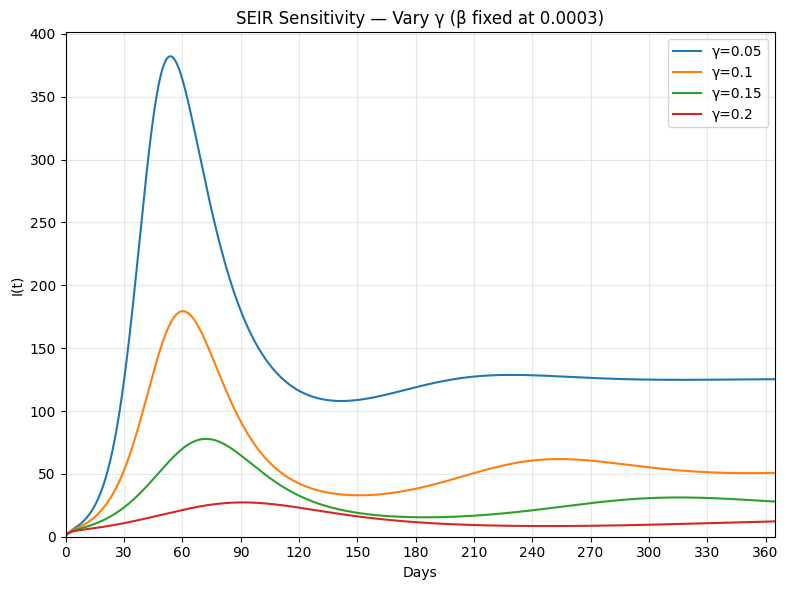

In [72]:
# effect of γ (hold β fixed)
peak_reports_gamma = []
plt.figure(figsize=(8, 6))
for gamma in gamma_grid:
    t, S, E, I, R = simulate_seir_rk45(S0, E0, I0, R0, beta_baseline, gamma, sigma, mu, t_end, dt)
    plt.plot(t, I, label=f"γ={gamma}")
    idx_peak = int(np.argmax(I))
    peak_reports_gamma.append((gamma, float(I[idx_peak]), float(t[idx_peak])))

plt.xlabel("Days")
plt.ylabel("I(t)")
plt.title("SEIR Sensitivity — Vary γ (β fixed at 0.0003)")
plt.legend()
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.set_xlim(0, t_end)
ax.set_xticks(list(range(0, int(t_end)+1, 30)))
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

From the second plot, when **γ** increases (0.05 → 0.2) while **β** is fixed at 0.0003, the infection curve shows **lower** peaks that occur **earlier**. A higher **γ** means faster recovery, so fewer individuals remain infectious, reducing the overall height of **I(t)** and shifting the peak forward in time.

In summary, a larger **β** makes the epidemic spread faster and stronger, while a larger **γ** shortens the infectious period and limits spread, with both effects clearly shown in the plotted curves.

#### ii. Plot the peak infection and total infections over a year for each β and γ combination.

In [73]:
labels = []
peak_vals = []
total_vals = []

for gamma in gamma_grid:
    for beta in beta_grid:
        t, S, E, I, R = simulate_seir_rk45(
            S0, E0, I0, R0,
            beta=beta, gamma=gamma, sigma=sigma, mu=mu,
            t_end=t_end, dt=dt
        )
        # Metrics
        peak_I = float(np.max(I))
        new_inf_rate = beta * S * I
        total_inf = float(np.trapz(new_inf_rate, t))

        labels.append(f"(β,γ)=({beta:.4f},{gamma:.2f})")
        peak_vals.append(peak_I)
        total_vals.append(total_inf)

x = np.arange(len(labels))

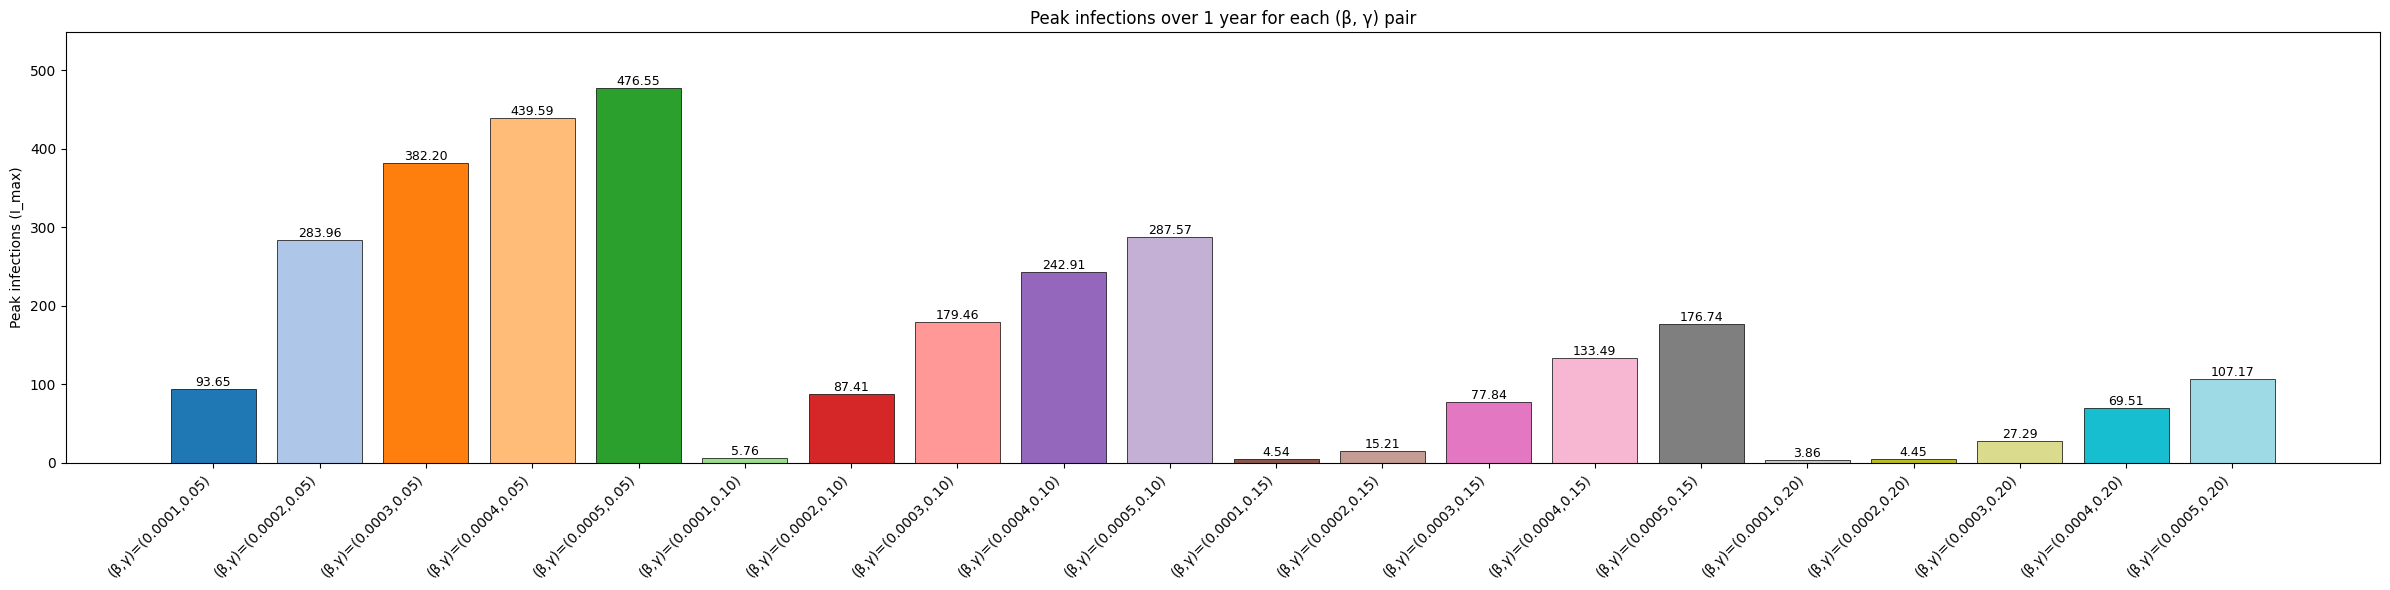

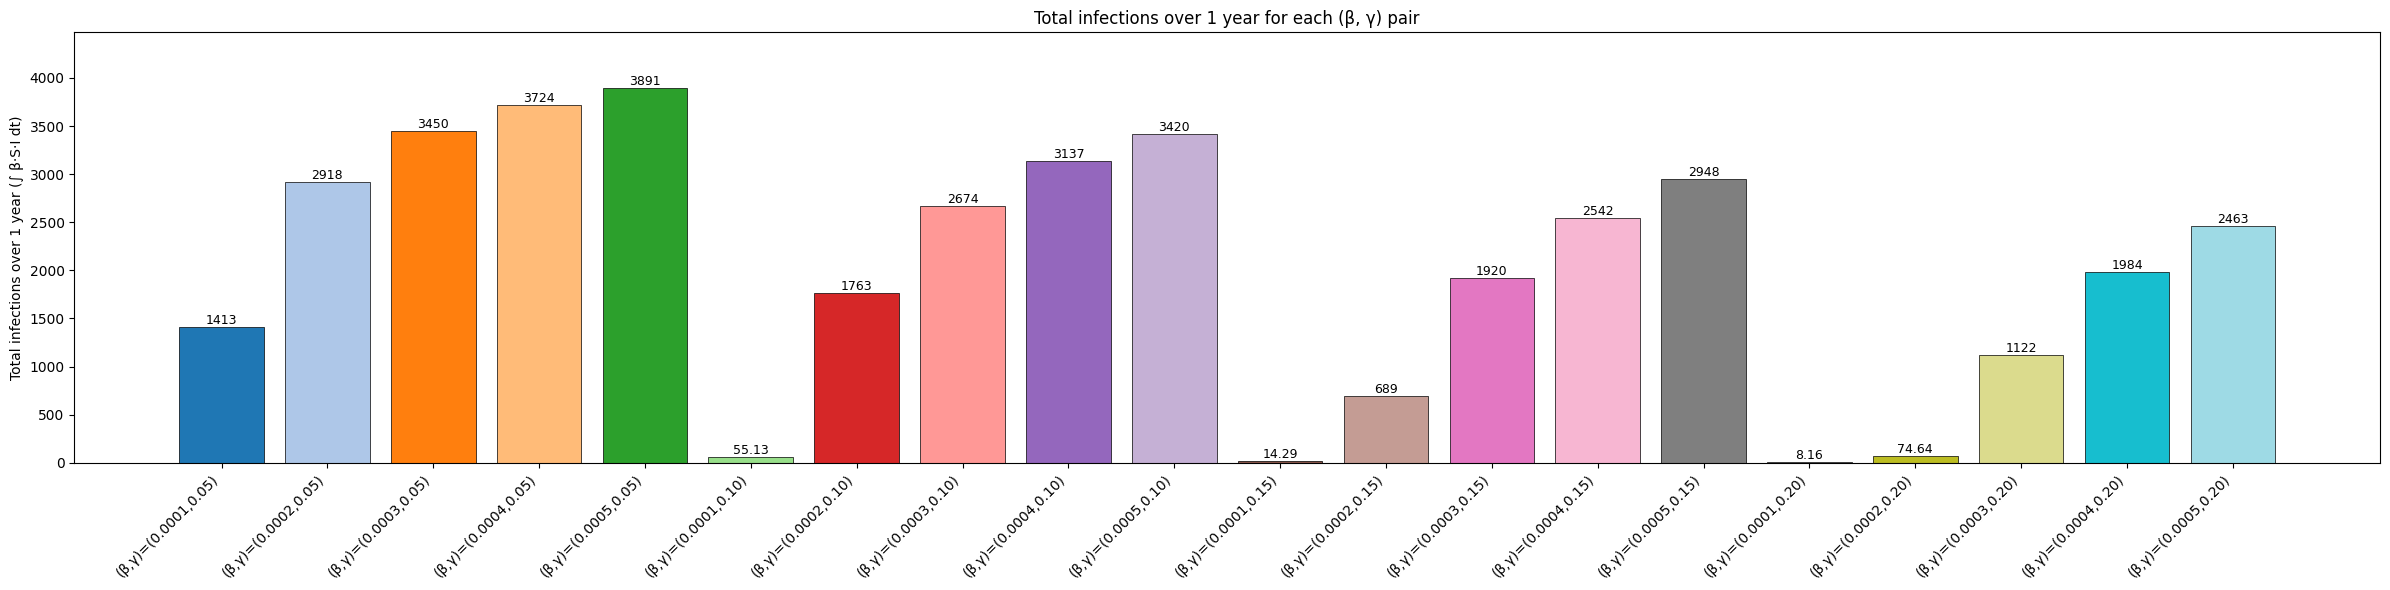

In [74]:
colors20 = plt.cm.tab20(np.linspace(0, 1, len(labels)))

# Plot 1: Peak infections (I_max)
plt.figure(figsize=(24, 6))
bars = plt.bar(x, peak_vals, color=colors20, edgecolor="black", linewidth=0.5)
plt.ylabel("Peak infections (I_max)")
plt.title("Peak infections over 1 year for each (β, γ) pair")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylim(0, max(peak_vals) * 1.15)

for i, v in enumerate(peak_vals):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Plot 2: Total infections (∫ β·S·I dt over 1 year)
plt.figure(figsize=(24, 6))
bars = plt.bar(x, total_vals, color=colors20, edgecolor="black", linewidth=0.5)
plt.ylabel("Total infections over 1 year (∫ β·S·I dt)")
plt.title("Total infections over 1 year for each (β, γ) pair")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylim(0, max(total_vals) * 1.15)

for i, v in enumerate(total_vals):
    label = f"{v:.0f}" if v >= 100 else f"{v:.2f}"
    plt.text(i, v, label, ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

From the bar plots, each column represents one **(β, γ)** pair over 1 year. It can be seen that as **β** increases (moving left to right within each γ group), both the **peak infections** and the **total infections** rise significantly. This pattern matches intuition — a higher β means stronger transmission, causing faster spread and more total cases.  

Across different γ values (comparing color groups), higher **γ** values shift the bars lower. A larger γ represents faster recovery, which reduces the infectious period and limits how high and how far the infection can spread.  

In short, when **β** is large and **γ** is small, the infection peaks sharply and affects more people overall. When **β** is small or **γ** is large, the outbreak remains smaller, with lower peaks and fewer total infections.

#### iii. Discuss the implications for public health interventions, relating β to social distancing and γ to medical treatments.

From the E(ii) bars: bigger **β** → higher peak and more total infections. Bigger **γ** → lower peak and fewer total infections.  

So the action is simple: **make β smaller** (cut contacts, masks/air, transmission-blocking vax) and **make γ larger** (fast test/isolation, treatment). Doing **β↓** and **γ↑** gives a smaller peak and fewer cases over the year, exactly what the bars showed.


### Novelty
Make only **β** seasonal: **β(t) = β · (1 + amp · sin(2πt/365))**, where `amp` sets the ±% swing around the baseline (e.g., `amp=0.20` → ±20%). Keep all other params the same, then compare constant-β vs seasonal-β(t) to see small oscillations in **I(t)** and shifts in peak/total infections.

In [ ]:
# all parameter are same as the E, only β changed.
S0, E0, I0, R0 = 990, 9, 1, 0
sigma = 0.2
mu    = 0.01
gamma = 0.10
beta  = 0.0003
t_end, dt = 365.0, 0.1

# Seasonal β(t) 
season_amp = 0.20    # ±20% around mean β
season_T   = 365.0   

def seir_rhs_const(t, y):
    S, E, I, R = y
    dS = -beta * S * I
    dE =  beta * S * I - sigma * E
    dI =  sigma * E - gamma * I
    dR =  gamma * I

    N = S + E + I + R
    dS += mu * N - mu * S
    dE += - mu * E
    dI += - mu * I
    dR += - mu * R
    return [dS, dE, dI, dR]

def beta_seasonal(t):
    return beta * (1.0 + season_amp * np.sin(2.0 * np.pi * t / season_T))

def seir_rhs_seasonal(t, y):
    S, E, I, R = y
    bt = beta_seasonal(t)
    dS = -bt * S * I
    dE =  bt * S * I - sigma * E
    dI =  sigma * E - gamma * I
    dR =  gamma * I

    N = S + E + I + R
    dS += mu * N - mu * S
    dE += - mu * E
    dI += - mu * I
    dR += - mu * R
    return [dS, dE, dI, dR]

def simulate(rhs):
    t_eval = np.arange(0.0, t_end + 1e-12, dt)
    sol = solve_ivp(rhs, (0.0, t_end), [S0, E0, I0, R0], method="RK45", t_eval=t_eval, max_step=dt, rtol=1e-6, atol=1e-9)
    return sol.t, *sol.y

[Constant β]  I_max=179.46 at t=60.3 d,  Total infections=2673.54
[Seasonal β]  I_max=206.86 at t=57.0 d,  Total infections=2588.20


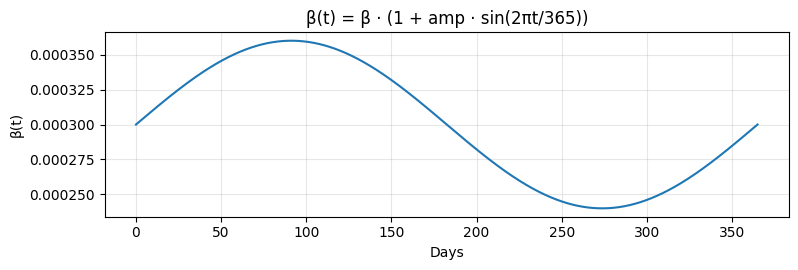

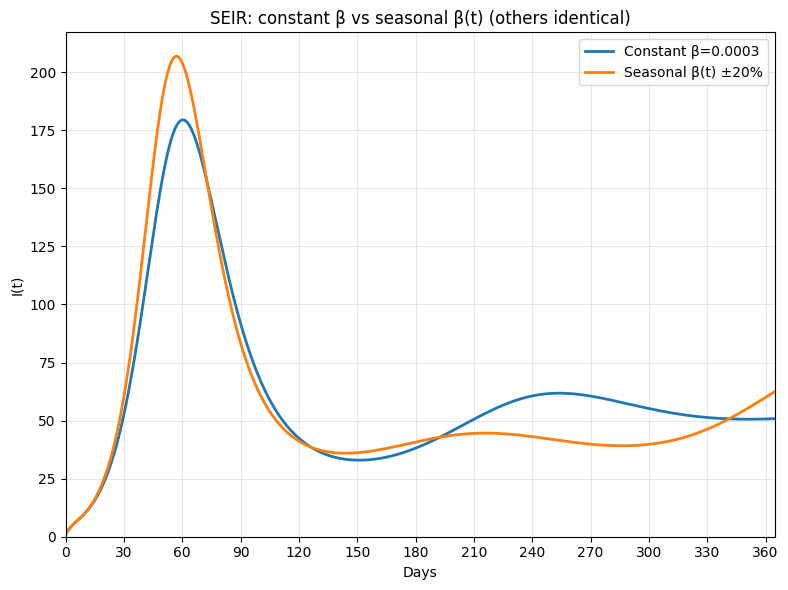

In [ ]:
t_c, S_c, E_c, I_c, R_c = simulate(seir_rhs_const)
t_s, S_s, E_s, I_s, R_s = simulate(seir_rhs_seasonal)

idx_c = int(np.argmax(I_c)); Imax_c = float(I_c[idx_c]); tpeak_c = float(t_c[idx_c])
idx_s = int(np.argmax(I_s)); Imax_s = float(I_s[idx_s]); tpeak_s = float(t_s[idx_s])

# Totals over 365 days (1 year): ∫ β(t)·S·I dt  (only β(t) differs)
total_c = float(np.trapz(beta * S_c * I_c, t_c))
beta_series_s = beta_seasonal(t_s)
total_s = float(np.trapz(beta_series_s * S_s * I_s, t_s))

print(f"[Constant β]  I_max={Imax_c:.2f} at t={tpeak_c:.1f} d,  Total infections={total_c:.2f}")
print(f"[Seasonal β]  I_max={Imax_s:.2f} at t={tpeak_s:.1f} d,  Total infections={total_s:.2f}")

plt.figure(figsize=(8, 2.8))
plt.plot(t_s, beta_series_s)
plt.xlabel("Days"); plt.ylabel("β(t)")
plt.title("β(t) = β · (1 + amp · sin(2πt/365))")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t_c, I_c, label=f"Constant β={beta}", linewidth=2)
plt.plot(t_s, I_s, label=f"Seasonal β(t) ±{int(season_amp*100)}%", linewidth=2)
plt.xlabel("Days"); plt.ylabel("I(t)")
plt.title("SEIR: constant β vs seasonal β(t) (others identical)")
plt.legend(); plt.grid(True, alpha=0.3)
ax = plt.gca(); ax.set_xlim(0, t_end); ax.set_xticks(list(range(0, int(t_end)+1, 30))); ax.set_ylim(bottom=0)
plt.tight_layout(); plt.show()

From the plot, seasonal β(t) makes the **first peak higher and a bit earlier** (β is above baseline early in the year), but the **yearly total is smaller** because β(t) dips below baseline later and damps the tail. Net: **bigger early surge, smaller total** over the year when β has a ±20% seasonal swing.